In [1]:
import ECCO_functions_v2 as ECCO

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import osgeo.ogr
import glob
from matplotlib.transforms import Bbox

%matplotlib inline

### First, reproduce the problem ###

In [7]:
 #4a8a86.npy  # big one
#atest = np.load('Metadata/Weights/4a586.npy')
#plt.imshow(atest,interpolation='none',cmap=plt.cm.gray,origin='lower')
#plt.show()
#atest.sum()

### Examine the problem in the catchment areas too###

In [5]:
# Read back catchment metadata from Catchment_weights_Meta() function..
catch_meta = pd.read_csv('Catchments/Metadata/Catchment_meta.csv')
catch_meta = catch_meta.set_index('EB_id')

In [6]:
catch_meta.index[1]

'd47c6'

In [10]:
# Example of reading the data from a hdf5 file after creation using the metdatada as a lookup
#filein = 'Catchments/Weights/catchment_weights.h5'
#f = h5py.File(filein,"r")

# Going to test the weighting for the lakes (.npy) files, and also for the catchment hdf5 file.
# will read them in a loop, and sum the pixels. Will stop if the weight masks are not equal to
# 1 at any time.

acnt = 0
for n in catch_meta.index:
    if catch_meta.npix[n] > 1:
        with h5py.File('Catchments/Weights/catchment_weights.h5','r') as fp:
            tmparray = fp[n]
            tmparray = tmparray[:,:]
        if tmparray.sum() < 0.99:
            acnt += 1.
            print n, tmparray.sum()
print 'Found problems in', acnt,' lakes'

# Found problems in 2026.0  lakes: too little weight
# Found problems in 2072.0  lakes: too much weight
# After change: Found problems in 0  lakes

32def3 0.989199
4ddcf7 0.987971
Found problems in 2.0  lakes


### Let's dig into the weighting function itself ###

In [4]:
def Fast_v3_stripped(nc_path, lake_file, lstart=0,lstop=275265,
                       hexlist=None,tt=None,plots = False):

    lk_processed_inf = pd.read_csv('Metadata/Meta_Lakes.csv')  # Pre-processed lake metadata (CSV)
    lk_processed_inf.index = lk_processed_inf.hex           # Use the hex-code column as the index 
    
    ShapeData = osgeo.ogr.Open(lake_file)                  # Make a link to Lake Shape Files
    TheLayer = ShapeData.GetLayer(iLayer=0)
    
    clim_dat,rlat,rlon,timeCDX,metadata,txtfname = ECCO.Read_CORDEX_V2(nc_path) # CORDEX NetCDF Read file
    vname, m1, m2, dexp, m3, m4, m5, m6, drange_orignial = metadata     # Metadata of fname string
    var_type = clim_dat.standard_name                                   # What kind of CORDEX data?
    dat_loaded = clim_dat[:,:,:]                                        # Load CORDEX data into RAM
    rlat_loaded = rlat[:]
    rlon_loaded = rlon[:]
    
    orog = ECCO.Height_CORDEX()                                 # NetCDF EUR-11 surface height data 
    
    precalculated = []                                     # Gather precalculated surface weights 
    for fnm in glob.glob("Metadata/Weights/*.npy"):           # N.b. You can precalculate as many as you
        precalculated.append(fnm[14:-4])                   # like: place in folder to run (for speed)
    precalculated = np.array(precalculated)                # Make it a np.array (needed for functions)
    
    if hexlist == None:                                    # Set up the list of lakes to process:
        dolakes=np.arange(lstart,lstop,1)          #If no Hexcodes, use lstart/lstop to form a list
    else:
        dolakes= lk_processed_inf.num[hexlist]     #If hexcodes, then gen. list of nums from PD object
    

    # 2. LOOP OVER ALL LAKES (or specified lakes from lstart to lstop)

    for n in dolakes:
        tlist = []
        feature1 = TheLayer.GetFeature(n)           # Get individ. lake in shapefile
        lake_feature = feature1.ExportToJson(as_object=True)
        lake_cart = ECCO.Path_LkIsl_ShpFile(lake_feature['geometry']['coordinates'])
        lake_altitude=lake_feature['properties']['stf_mean']
        EB_id = lake_feature['properties']['EBhex']
        EB_id = EB_id[2:]                           # Strip off the hexcode label 0x
        lake_rprj = ECCO.Path_Reproj(lake_cart,False)    # Reproj. lake to CORDEX plr. rotated

        if plots:     
            ECCO.Preview_Lake(lake_cart)        
            print 'Area in km^2 (not inc. islands):', ECCO.Area_Lake_and_Islands(lake_cart),         
            print ', No. xy bound. points:',len(lake_cart.vertices)
            
        sub_clim,sub_rlat,sub_rlon = ECCO.TrimToLake(lake_rprj,dat_loaded[0,:,:],
                                                             rlat_loaded,
                                                        rlon_loaded,off = 3, show = False) 
        
        #return lake_rprj,sub_clim,sub_rlat,sub_rlon
        
        weight_mask = ECCO.Pixel_Weights(lake_rprj,sub_clim,sub_rlat,sub_rlon)
            
        return weight_mask
        '''            
            if ((var_type == 'air_temperature')| (var_type == 'surface_air_pressure')): 
                sub_orog,sub_rlat,sub_rlon = ECCO.TrimToLake(lake_rprj,orog,rlat_loaded,
                                                            rlon_loaded,off = 3, show = False)
                #print 'Stats 2:',n,EB_id,lake_altitude
                if lake_altitude == None:                 # Some lakes don't have alitude values
                    offset = -999.
                else:
                    hght,offset = ECCO.Orographic_Adjustment(weight_mask,sub_orog,
                                                        lake_altitude,clim_dat,chatty=False)
            else:
                hght = -999.                         # If no offset calculated then
                offset = -999.                       # just set them to missing data
            
            #return weight_mask # Break here
            
            sub_clim,sub_rlat,sub_rlon = ECCO.TrimToLake3D(lake_rprj,dat_loaded,rlat_loaded,rlon_loaded,
                                                      off = 3, show = False)
            tlist = ECCO.Weighted_Mean_3D(weight_mask, sub_clim, chatty=False)  # Here's the t-series
            tlist = np.squeeze(tlist)                                      # Remove empty dimension
            
            if plots:
                ECCO.Show_LakeAndData(lake_rprj,dat_loaded[0,:,:],rlat,rlon,zoom=6.)
                ECCO.Preview_Weights(lake_rprj,weight_mask,sub_rlat,sub_rlon) 
    return
    '''

In [5]:
#def Fast_v3_stripped(nc_path, lake_file, outputprefix,lstart=0,lstop=275265,
#                       hexlist=None,tt=None,plots = False):

nc_path = 'CORDEX/tas_EUR-11_ICHEC-EC-EARTH_rcp45_r1i1p1_KNMI-RACMO22E_v1_day_20960101-21001231.nc'
lake_file = 'Lakes/Lake_v0.2/ecco-biwa_lakes_v.0.2.shp'

# Get what you need to work directly on the pixel weight algorithm (for big lake 78 pixels)
#lake_rprj,sub_clim,sub_rlat,sub_rlon = Fast_v3_stripped(nc_path = nc_path, lake_file = lake_file, hexlist=['4a8a86'])
# Small lake - one pixel...
#lake_rprj,sub_clim,sub_rlat,sub_rlon = Fast_v3_stripped(nc_path = nc_path, lake_file = lake_file, hexlist=['4a586'])

weight_mask = Fast_v3_stripped(nc_path = nc_path, lake_file = lake_file, hexlist=['4a586'])

In [26]:
#weight_mask = Pixel_Weights(lake_rprj,sub_clim,sub_rlat,sub_rlon)
acheck,tmpbb,lout = weights_version2(lake_rprj,sub_clim,sub_rlat,sub_rlon)

At least 3 points inside? False
All corners inside lake? False
Any pixel within the boundary box? True


Okay, now I can reproduce the error. And I have iscolated the function that gives the bad result. Now, the job is to fix it. Then I also want to update this code like the cathcments
to use surface weightings for all multi-pixel data (create a hdf5 mask). Digression - also see if I can speed up the the catchments feature conversion part.

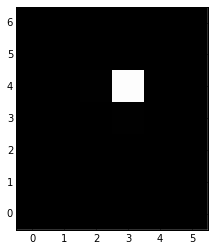

1.0050793622346634

In [6]:
plt.imshow(weight_mask,interpolation='none',cmap=plt.cm.gray,origin='lower')
plt.show()

#plt.plot(weight_mask[:,10]) # Transect across the lake
#plt.show()

weight_mask.sum()

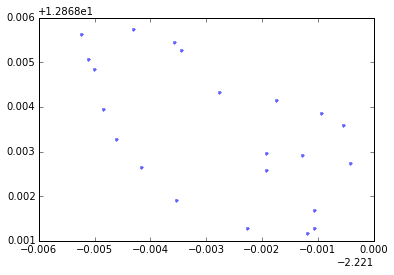

In [27]:
lout = lake_rprj

xlist=[]
ylist=[]
for n in lout.vertices:
    x,y = n
    xlist.append(x)
    ylist.append(y)

bxlist = []
bylist = []
ahold = tmpbb.corners()
for n in ahold:
    x,y = n
    bxlist.append(x)
    bylist.append(y) 

    

plt.plot(xlist,ylist,'.b',alpha=0.6)  #tmpbb#,
#plt.plot(bxlist,bylist,'.r',alpha=0.8)


In [158]:
# Four possibilities:
# 1. no lake in pixel      (bcheck = false, isect_check = false)  : Do NOTHING
# 2. some lake in pixel    (bcheck = True, isect_check = True)    : Do thing
# 3. all lake within pixel (bcheck=True, isect = True)            : Do thing
# 4. pxl fully within lake (bcheck = False, isect = True)         : Do thing

lims = tmpbb.corners()  # Get the corners of the bounding box

# This will be true if there are any lake vectors WITHIN the pixel.
acheck = [((n[0] > lims[0][0])&(n[0]<lims[1][0])&(n[1] >lims[0][1])&\
                (n[1]<lims[1][1])) for n in lout.vertices]

bcheck = True in acheck  # See if a True value exists in acheck ANYWHERE

isect_check = lout.intersects_bbox(tmpbb)  # True if the lake intersects or 
# is bigger than pixel. nb. this doesnt always catch the small bits, which is why
# I need to use acheck too. AS this is really to pick up sitaution 4.
# Use both to see what is what (as just bcheck alone can sometimes miss lake).

#isect_check = False # Set manually for control flow testing
#bcheck = False

print 'Bcheck:',bcheck, 'iSect:',isect_check

if bcheck or isect_check:
    print 'Doing thing'
else:
    print 'Not doing thing, all false'

Bcheck: False iSect: 1
Doing thing


In [156]:
# bottom-left[0], upper-left[1], lower-right[2],upper-right[3]  
boxcorners = tmpbb.corners()
boxcorners

array([[-2.78166667,  8.45166667],
       [-2.78166667,  8.55433333],
       [-2.679     ,  8.45166667],
       [-2.679     ,  8.55433333]])

In [176]:
# If there is lake in the pixel, then the verticies should be 

acheck = [((n[0] > lims[0][0])&(n[0]<lims[1][0])&(n[1] >lims[0][1])&\
                (n[1]<lims[1][1])) 
          or (n[0] )
          
          
          for n in lout.vertices]



bx,by = boxcorners[0]
lx,ly = lout.vertices[0]
print bx,by
print lx,ly

#print (bx,by) < (lx,ly)
print lout.intersects_bbox(tmpbb)

lims2 =np.array([[-3.2,8.4],[-3.0,8.8]])  # 2D np.array for the BB object
tmpbb2 = Bbox(lims2)

print lout.intersects_bbox(tmpbb2)


-2.78166666667 8.45166666667
-2.0263507934 8.34919209364
True
1
0


In [185]:
cnrs =  tmpbb.corners()

acheck = [ ((n[0] > cnrs[0][0]) & (n[0] < cnrs[2][0])&
            (n[1] > cnrs[0][1])&(n[1] < cnrs[1][1]))                # within a box
           or ((n[0] > xmin)&(n[0]<xmax)&(n[1]>ymin)&(n[1]<ymax))   # shape encompasses a box  
          for n in lout.vertices]

[-2.02635079  8.34919209]


array([-2.78166667,  8.45166667])

In [237]:
print lout.vertices[0]
print ''
cnrs =  tmpbb.corners()
print cnrs[0]
print tmpbb.corners()


print 'show:',tmpbb.contains(lout.vertices[0][0],lout.vertices[0][1])
print 'show2:',lout.contains_points(cnrs)

vtest = [tmpbb.contains(n[0],n[1]) for n in lout.vertices]

print(len(vtest))



[-2.02635079  8.34919209]

[-2.78166667  8.45166667]
[[-2.78166667  8.45166667]
 [-2.78166667  8.55433333]
 [-2.679       8.45166667]
 [-2.679       8.55433333]]
show: False
show2: [False False False False]
33547


In [ ]:
bbb = tmpbb.get_points

In [ ]:
bbb = tmpbb.count_contains

In [ ]:
bbb = tmpbb.fully_contains

In [ ]:
bbb = tmpbb.contain

In [ ]:
bbb = lout.contains_point

In [ ]:
bbb = lout.contains_points

In [247]:
# Verteci test (does the bounding box have an xy within it?)
vtest = [tmpbb.contains(n[0],n[1]) for n in lout.vertices]
vmask = vtest == True
print lout.vertices[vmask], len(lout.vertices[vmask])
# If there are not enough to make a new path then ignore
if len(lout.vertices[vmask]) > 6: btest = 1
# If all the pixels are true (lake is within the pixel entireley) then set as 1 and leave

# Encompassing test (is the pixel within the shape?)
cnrs =  tmpbb.corners() # Get an xy np array of the 4 BB corners
cnr_test = lout.contains_points(cnrs)



In [271]:
sub_rlat[0]

7.4249999999999998

In [94]:
def weights_version2(lake_in, datin,lat_atts,lon_atts):
    '''
    Four possibilities:
    1. no lake in pixel      (bcheck = false, isect_check = false)  : Do NOTHING
    2. some lake in pixel    (bcheck = True, isect_check = True)    : Do thing
    3. all lake within pixel (bcheck=True, isect = True)            : Do thing
    4. pxl fully within lake (bcheck = False, isect = True)         : Do thing
    
    '''
    fillone = 0
    lout = lake_in
    pix_weights = np.zeros(np.shape(datin))
    cnt = 0
    latstep = ((lat_atts[-1]) - (lat_atts[0])) / (len(lat_atts))
    lonstep = ((lon_atts[-1]) - (lon_atts[0])) / (len(lon_atts))
    xvar = lon_atts[0] ; yvar= lat_atts[0]       # Initialize
    for gx,x in enumerate(xrange(len(lon_atts))):
        if(x == 0):  
            x_ll = lon_atts[0]            # set the lower left cnr as first lon val
            x_ur = lonstep + x_ll         # and the upper right, to be the x_ll + inc
        if(x > 0):                        # If already in the loop, use older x_ll,x_ur
            x_ll = x_ur                   # to continue calculating the B-box area
            x_ur = x_ll + lonstep    
        for gy,y in enumerate(xrange(len(lat_atts))):
            #print 'XY position:',gx,gy
            if(y == 0):
                y_ll = lat_atts[0]
                y_ur = latstep + y_ll
            if(y > 0):
                y_ll = y_ur
                y_ur = y_ll + latstep  
            lims =np.array([[x_ll,y_ll],[x_ur,y_ur]])  # 2D np.array for the BB object
            tmpbb = Bbox(lims)
            bcheck = False
            cnr_check = False
            # Verteci test (does the bounding box have an xy within it?)
            vtest = [tmpbb.contains(n[0],n[1]) for n in lout.vertices]
            vmask = vtest == True
            #print lout.vertices[vmask], len(lout.vertices[vmask])
            # If there are enough points to make a new path then set btest to True
            if len(lout.vertices[vmask]) > 6: bcheck = True
            # If all the pixels are true (lake is within the pixel entireley) then set as 1 and leave

            # Encompassing test (is the pixel within the shape?)
            cnrs =  tmpbb.corners() # Get an xy np array of the 4 BB corners
            cnr_test = lout.contains_points(cnrs)
            if len(cnr_test[cnr_test]) == 4: cnr_check = True
            
            # This will be true if there are any lake vectors WITHIN the pixel.
            acheck = [((n[0] > lims[0][0])&(n[0]<lims[1][0])&(n[1] >lims[0][1])&\
                        (n[1]<lims[1][1])) for n in lout.vertices]
            b2check = True in acheck  # See if a True value exists in acheck ANYWHERE
            
            
            if gx == 3 and gy == 4:
                print 'At least 3 points inside?', bcheck
                print 'All corners inside lake?', cnr_check
                print 'Any pixel within the boundary box?',b2check
                #return acheck,tmpbb,lout
            
            
            if bcheck or cnr_check or b2check:  # Execute for all situations except num.1
                #print 'Doing thing, at least on condition true'
                cnt = cnt + 1                 # Counter is just for testing.
                #pix_weights[y,x] = 0.0  # For Lake pix calc. and the frac area (%)
                sub_lout =[] 
                area_sub = []
                sub_lout = lout.clip_to_bbox(tmpbb,inside ='True')
                sub_lout = ECCO.BBOX_PathCode_Fix(sub_lout) # Corrects the 79 code error
                area_sub = ECCO.Area_Lake_and_Islands(sub_lout)
                lkarea = ECCO.Area_Lake_and_Islands(lout)
                if lkarea > 0.1:  # Added 4 Dec 2014 to combat a bug from small lakes
                    print 'Area more than 0.1km',area_sub,lkarea
                    pix_weights[y,x]= area_sub/lkarea

                if lkarea < 0.1:
                    print 'Area less than 0.1km!'
                    if fillone == 0:
                        pix_weights[y,x] = 1.
                    fillone = fillone + 1           
            else:
                pass
                #print 'Not doing anything, all conditions false'   
    return pix_weights

In [92]:
wmask = weights_version2(lake_rprj,sub_clim,sub_rlat,sub_rlon)

At least 3 points inside? False
All corners inside lake? False
Any pixel within the boundary box? True
Area more than 0.1km 0.135322399205 0.134638521384


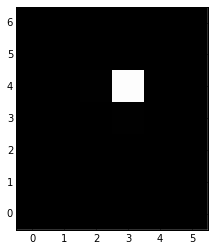

1.0050793622346634

In [93]:
plt.imshow(wmask,interpolation='none',cmap=plt.cm.gray,origin='lower')
plt.show()

#plt.plot(wmask[:,10]) # Transect across the lake
#plt.show()

wmask.sum()

In [90]:
def Area_Lake_and_Islands(lake_poly):
    '''Purpose  -  Calculate the area of a given Lake polygon, taking into account islands.
    Input - Lake polygon object (which may or may not include islands). Polygon object 
            should be generated with the function Path_Lake_and_Islands().
    Output- If islands are present the output is the area (in km^2) of the lake boundary
            minus the sum of the island(s) area. If no islands are present then the output
            is simply the area of the lake boundary.
    '''
    aaa = np.where(lake_poly.codes == 1)
    bbb = np.where(lake_poly.codes == 79)
    #print 'number of 1s:',len(aaa[0])
    #print 'number of 79s',len(bbb[0])
    island_num = (len(aaa[0]))-1
    #print 'Found %i Islands'%island_num
    area_start = [i for n,i in enumerate(aaa[0])]
    area_end = [i for n,i in enumerate(bbb[0])]
    #Seperated paths, pos.0 is the boundary and rest are islands
    sep_paths = [lake_poly.vertices[area_start[n]:area_end[n]] for n,i in enumerate(area_start)]
    #return sep_paths
    sep_areas = [(Poly_Area2D_precise(ECCO.EqArea(sep_paths[n]))) for n in xrange(len(sep_paths))]
    if island_num > 0:
        total = sep_areas[0] - sum(sep_areas[1:])
        #print 'Area minus Islands:',total
    else:
        total = sep_areas[0]
        #print 'No islands found, total area is simply lake boundary'
    #print 'Area without considering islands:',sep_areas[0]
    return total

In [81]:
def Poly_Area2D_precise(poly):
    '''
    Updated 29/04/2015 BAL to fix a precision error. But old 
    function (Poly_Area2D) kept unchanged for rest of code.
    Purpose - This function implements Green's Theorem to
    calculate area of a polygon in a 2D co-ordinate system.
    Input   - A polygon, as the verticies of a Matplotlib.Path 
    Notes   - More info at http://code.activestate.com/recipes/
                           578275-2d-polygon-area
    Join this function with EqArea function to find the area of a
    lake in km^2.
    Example - area = Poly_area2D(EqArea(A_Lake_Path.vertices))
    '''
    total = 0.0
    N = len(poly)
    for i in range(N):
        v1 = poly[i]
        v2 = poly[(i+1) % N]
        total += v1[0]*v2[1] - v1[1]*v2[0]
    return abs(total/2.)  

In [84]:
btest = Area_Lake_and_Islands(lake_poly=lake_rprj)
print (Poly_Area2D_precise(ECCO.EqArea(btest[0])))

0.134638521384


In [ ]:
0.134638521384